# Automatically Identifying Prediction Errors of Home Mortgage Loans: Complete Workbook
#### Alex Reibman 10/28/2017

When issuing loans, mortgage sellers are interested in protecting themselves against large forecasting errors. Although advances in statistical methods have allowed analysts to achieve relatively low prediction errors, exceptionally large and unlikely errors are still pervasive threats to otherwise sound portfolios. However, given a dataset of loans, it is possible to develop a machine learning model to foresee such exceptionally large errors, termed “hotspots”, in advance. In this paper, I demonstrate an ensemble machine learning model that performs exceptionally well at identifying prediction hotspots for loan defaults, balances, and prepayments. Scores for each class generate precision, recall, and accuracy levels that are nearly prefect. Furthermore, unlike popular methods like deep learning, the model is developed in such a way that intuition is not lost in a black box. 

First, each necessary library is imported:

In [1]:
import os
from __future__ import division
import math
import sklearn
from sklearn.metrics import classification_report
from sklearn import preprocessing
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

%matplotlib inline

### Preprocessing:
The following cells demonstrate the process of cleaning and formatting the data so that it can be used properly

In [2]:
# Import
df = pd.read_csv("hotspot.csv")

C:\Users\Akrylic\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Upon examining the data, it becomes clear that the first row is not needed.
df.head(2)

,Month,Debt to income ratio,Loan to value ratio,Credit score,Region,Product type code,Vintage: year loan was originated,Actual unpaid balance ($),Actual prepayment amount ($),Actual default amount ($),Predicted unpaid balance ($),Predicted prepayment amount ($),Predicted default amount ($)
0,month,dti,ltv,cs,region,prodtype,vintage,balance,pp,default,balance_pred,pp_pred,default_pred
1,1,5,0.4,30,MIDWEST,A,2010,2555811.169,132792.4449,11396.3856,2483557.224,193587.577,22855.19923


A quick look of the data shows us that there are some errors in the CSV's formatting for instance, there are 24 unique months.

In [4]:
df.columns = df.iloc[0]
df = df.drop(df.index[0])
print("Quick look")
display(df.head())
 
print("Summary Statistics")
display(df.describe())

Quick look


,month,dti,ltv,cs,region,prodtype,vintage,balance,pp,default,balance_pred,pp_pred,default_pred
1,1,5,0.4,30,MIDWEST,A,2010,2555811.169,132792.4449,11396.3856,2483557.224,193587.577,22855.19923
2,2,5,0.4,30,MIDWEST,A,2010,2324197.09,121211.5764,10402.50344,2191575.788,171709.2233,20272.21255
3,3,5,0.4,30,MIDWEST,A,2010,2104510.211,110227.0764,9459.802234,1922164.807,151522.088,17888.89331
4,4,5,0.4,30,MIDWEST,A,2010,1896136.33,99808.23437,8565.646383,1673579.561,132895.4384,15689.807
5,5,5,0.4,30,MIDWEST,A,2010,1698492.873,89925.92113,7717.535992,1444210.202,115708.6472,13660.71225


Summary Statistics


,month,dti,ltv,cs,region,prodtype,vintage,balance,pp,default,balance_pred,pp_pred,default_pred
count,241920,241920,241920.0,241920,241920,241920,241920,241920,241920.0000,241920,241920,241920.0000,241920.00000
unique,24,10,12.0,16,4,3,8,9828,11286.0000,11325,123506,115272.0000,115877.00000
top,12,25,0.8,100,NORTHEAST,C,2010,812168.1829,379343.8435,30763.43937,2352881.328,167936.4164,90132.98653
freq,14699,35280,29400.0,22320,60480,80640,34560,69,318.0000,267,10,273.0000,54.00000


Due to the short time periods of the data (12 months), it is possible to develop a model using traditional continuous classification techniques. Each month is encoded as a dummy variable within the model since the prediction error gets worse as the loan grows older. Furthermore, region type, vintage year, and product type are also all encoded as dummy variables. 

In [5]:
#One-hot encoding
df['vintage']=df['vintage'].apply(pd.to_numeric)
df = df.join(pd.get_dummies(df['vintage'],prefix='vintage'))
df = df.drop(['vintage'],axis=1)

df['month']=df['month'].apply(pd.to_numeric)
df = df.join(pd.get_dummies(df['month'],prefix='month'))
df = df.drop(['month'],axis=1)

df = df.join(pd.get_dummies(df['region'],prefix='region'))
df = df.drop(['region'],axis=1)

df = df.join(pd.get_dummies(df['prodtype'],prefix='prodtype'))
df = df.drop(['prodtype'],axis=1)

In [6]:
df.head()

,dti,ltv,cs,balance,pp,default,balance_pred,pp_pred,default_pred,vintage_2010,...,month_10,month_11,month_12,region_MIDWEST,region_NORTHEAST,region_SOUTH,region_WEST,prodtype_A,prodtype_B,prodtype_C
1,5,0.4,30,2555811.169,132792.4449,11396.3856,2483557.224,193587.577,22855.19923,1,...,0,0,0,1,0,0,0,1,0,0
2,5,0.4,30,2324197.09,121211.5764,10402.50344,2191575.788,171709.2233,20272.21255,1,...,0,0,0,1,0,0,0,1,0,0
3,5,0.4,30,2104510.211,110227.0764,9459.802234,1922164.807,151522.088,17888.89331,1,...,0,0,0,1,0,0,0,1,0,0
4,5,0.4,30,1896136.33,99808.23437,8565.646383,1673579.561,132895.4384,15689.807,1,...,0,0,0,1,0,0,0,1,0,0
5,5,0.4,30,1698492.873,89925.92113,7717.535992,1444210.202,115708.6472,13660.71225,1,...,0,0,0,1,0,0,0,1,0,0


In [7]:
# Reload dataframe as numeric to avoid type confusion
df = df.apply(pd.to_numeric)
df.columns = df.columns.astype(str)

### Defining error terms
The prediction error can be calculated for each hotspot class by subtracting the predicted amount from the actual amount. 

Unless data problem has no noise whatsoever, prediction errors will always exist. However, noise almost always exists in real world data, so prediction errors are inevitable. The error term `e` is assumed to be independent and normally distributed around a mean of zero. The error distributions seem to illustrate this assumption: 

In [8]:
df['pp_error'] = df['pp_pred']-df['pp']
df['balance_error'] = df['balance_pred']-df['balance']
df['default_error'] = df['default_pred']-df['default']

The following graphs illustrate the differences between the analyst's predictions and the actual outcomes for defaults, prepayments, and balances:

(array([      0.,   20000.,   40000.,   60000.,   80000.,  100000.,
         120000.,  140000.,  160000.,  180000.]),
 <a list of 10 Text yticklabel objects>)

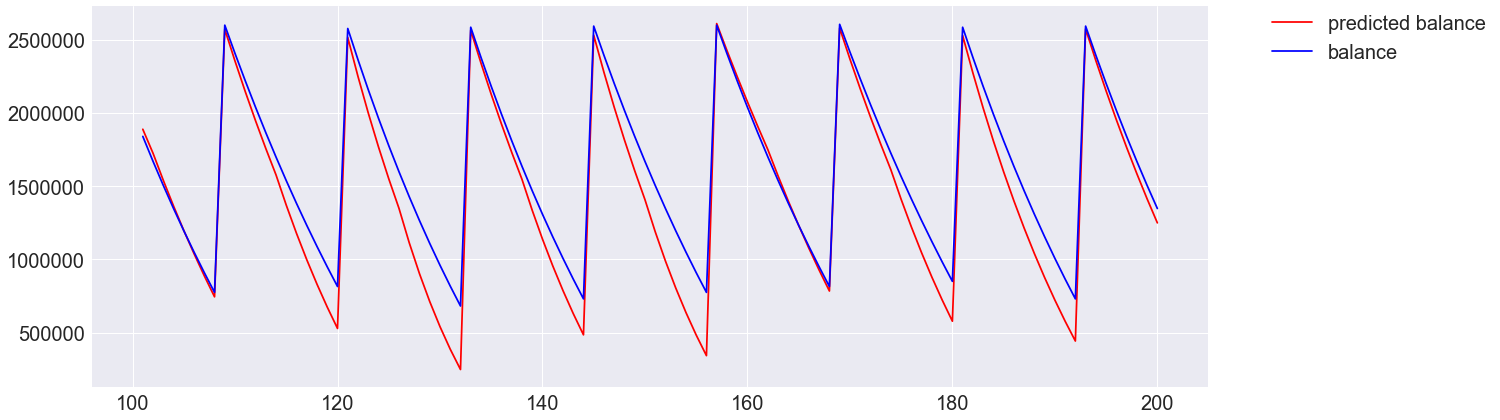

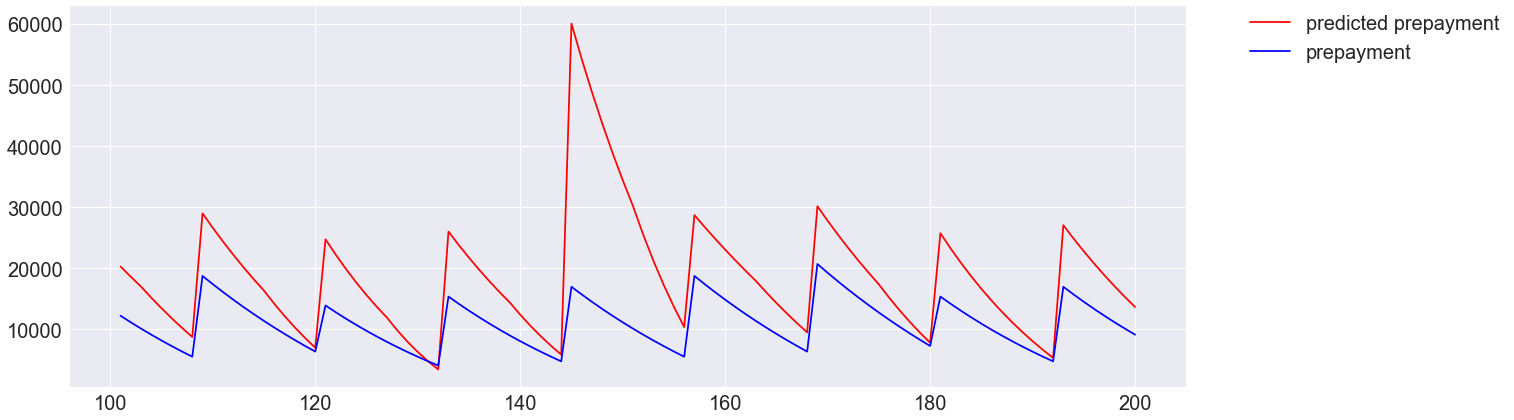

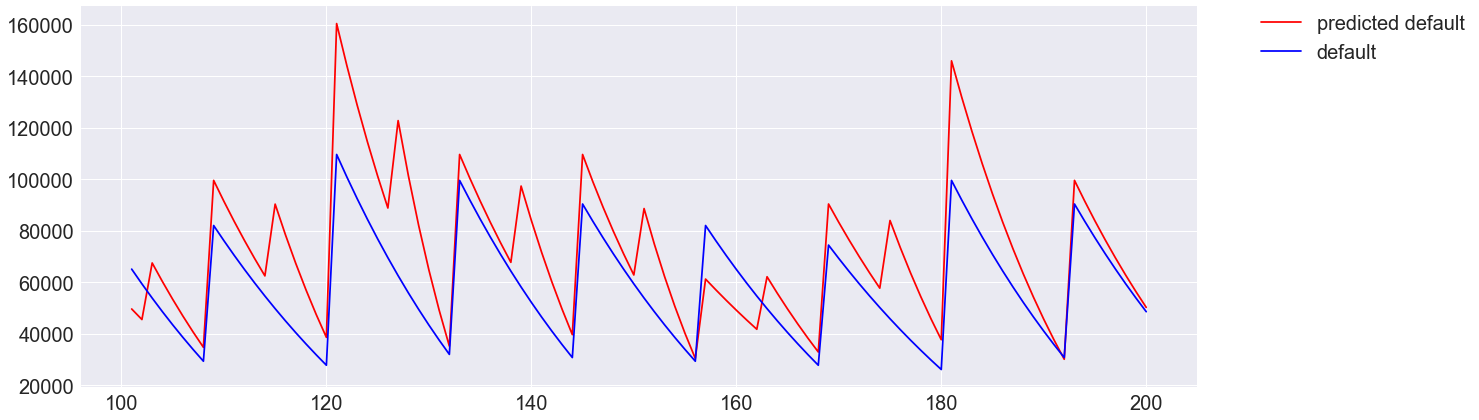

In [9]:
#Graph differences between predictions and outcomes
fig = plt.figure(1, figsize=(20,7))
plt.plot(df.index[100:200],df['balance_pred'][100:200], color='r', label="predicted balance")
plt.plot(df.index[100:200],df['balance'][100:200], color='b', label="balance")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.figure(2, figsize=(20,7))
plt.plot(df.index[100:200],df['default_pred'][100:200], color='r', label="predicted prepayment")
plt.plot(df.index[100:200],df['default'][100:200], color='b', label='prepayment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.figure(3, figsize=(20,7))
plt.plot(df.index[100:200],df['pp_pred'][100:200], color='r', label="predicted default")
plt.plot(df.index[100:200],df['pp'][100:200], color='b', label="default")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



The following graphs illustrate the trend of the errors over a small sample of time:

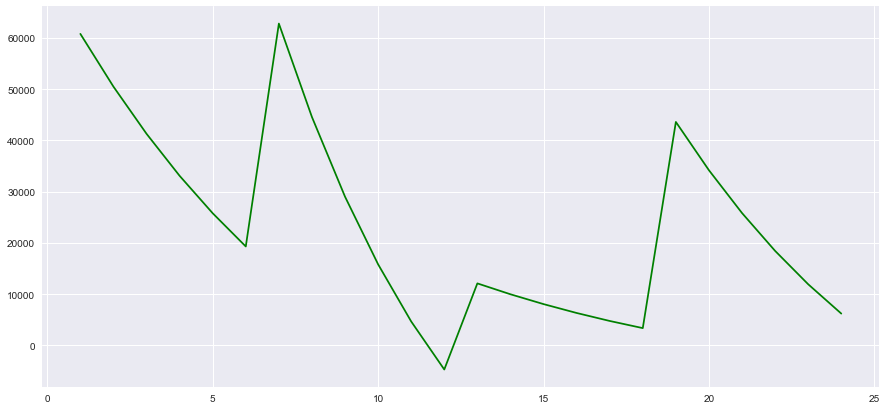

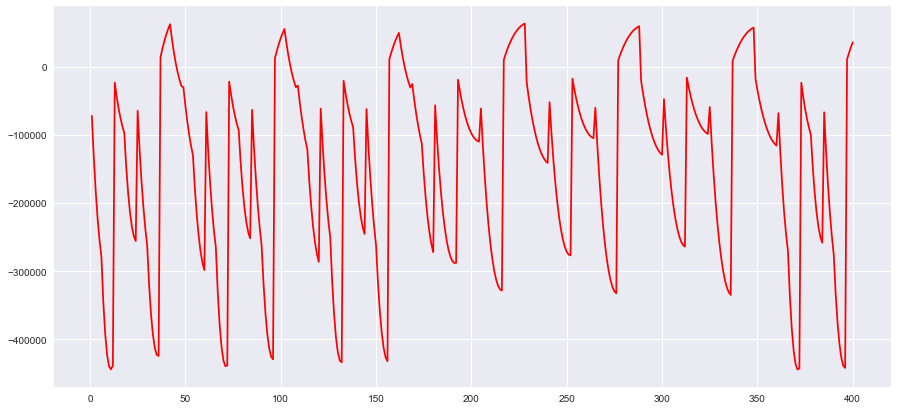

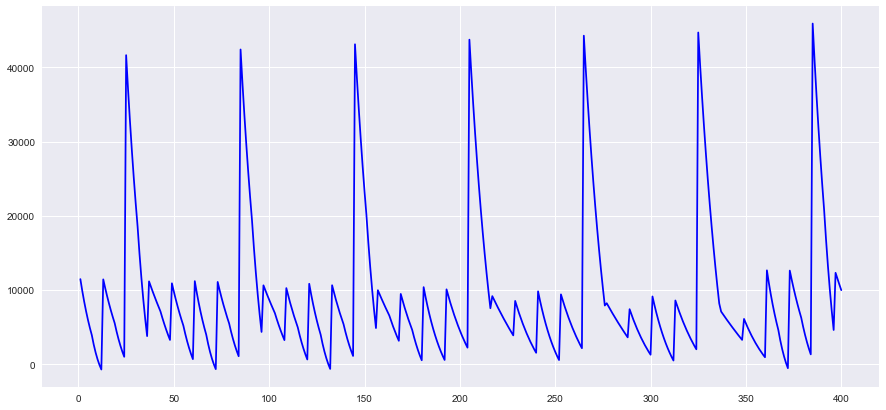

In [10]:
plt.figure(1, figsize=(15,7))
plt.plot(df.index[:24],df['pp_error'][:24], color='green')

plt.figure(2, figsize=(15,7))
plt.plot(df.index[:400],df['balance_error'][:400], color='red')

plt.figure(3, figsize=(15,7))
plt.plot(df.index[:400],df['default_error'][:400], color='blue')


By plotting the distrtibutions of the predictions and the actual outcomes respectively, we can see that the predictions follow a very different distribution than the actual outcomes do.

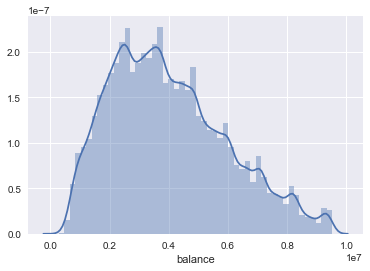

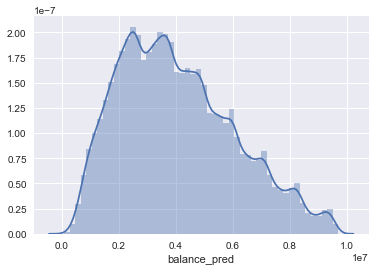

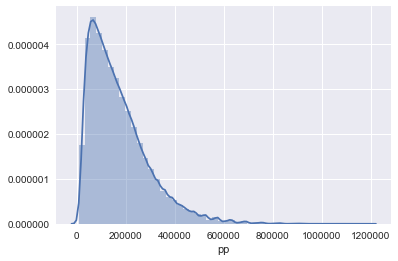

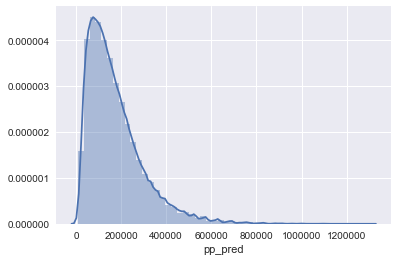

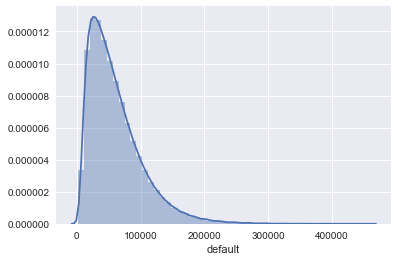

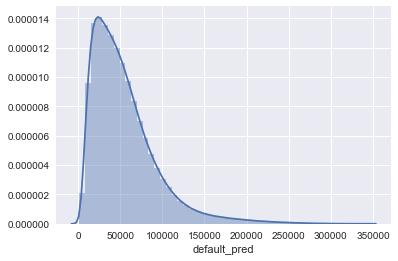

In [11]:
for dist in ('balance','balance_pred','pp','pp_pred','default','default_pred'):
    plt.figure()
    sns.distplot(df[dist])

Futhermore, we can plot the distributions of the error spreads to get a better visualize the bias and variance of the errors.

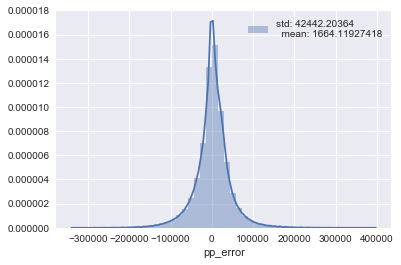

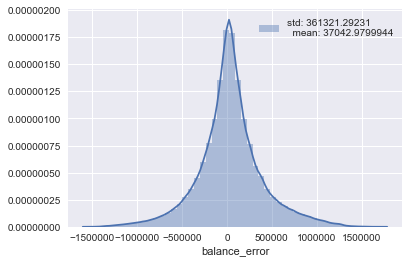

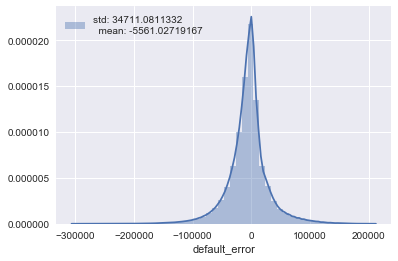

In [12]:
for dist in ('pp_error','balance_error','default_error'):
    plt.figure()
    sns.distplot(df[dist], label="std: "+str(np.std(df[dist])) + " \n  mean: "+str(np.mean(df[dist])))
    plt.legend()

### Time Dependence
Given that the data is presented as time series data, months are a feature worth encoding. This is demonstrable since as the year progresses, the variance of the distribution grows.

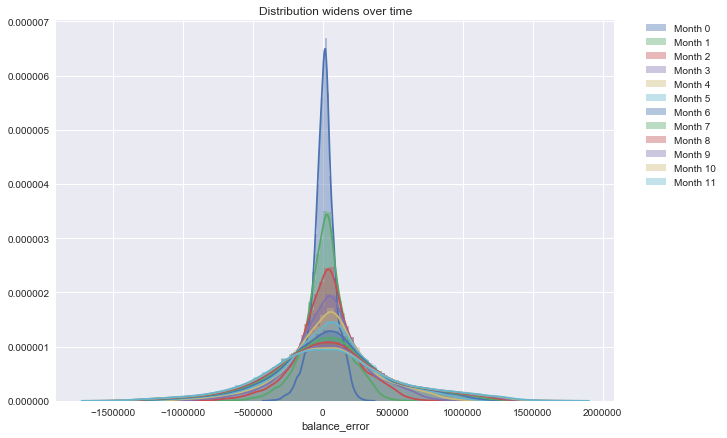

In [13]:
distlist = []
for i in xrange(1,13):
    distlist.append(df.query('month_'+str(i)+'==1')['balance_error'])
    
plt.figure(figsize=(10,7))
for count, dist in enumerate(distlist):
    sns.distplot(dist, label="Month "+str(count))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 10)
plt.title("Distribution widens over time")


Additionally, this shows the error growth over time:

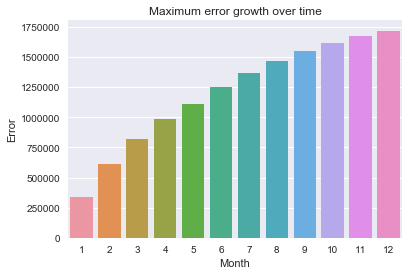

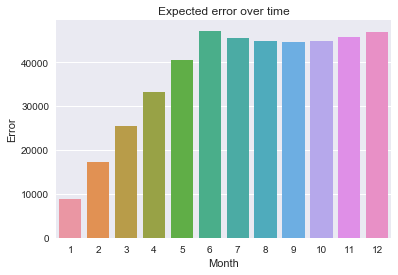

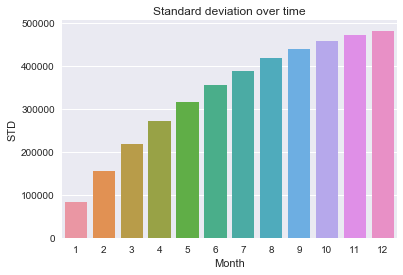

In [14]:
plt.figure()
sns.barplot(x=[x for x in range(1,len(distlist)+1)],y=[max(dist) for dist in distlist])
plt.xlabel("Month")
plt.ylabel("Error")
plt.title("Maximum error growth over time")

plt.figure(2)
sns.barplot(x=[x for x in range(1,len(distlist)+1)],y=[np.mean(dist) for dist in distlist])
plt.xlabel("Month")
plt.ylabel("Error")
plt.title("Expected error over time")

plt.figure(3)
sns.barplot(x=[x for x in range(1,len(distlist)+1)],y=[np.std(dist) for dist in distlist])
plt.xlabel("Month")
plt.ylabel("STD")
plt.title("Standard deviation over time")

For the purposes of this case, the term “hotspots” is used simply to denote an unlikely event. Given the arbitrariness of the term, I take the liberty to define it as any error outside of 2 standard deviations from the mean.

In [15]:
# Definining hotspot series
pp_error = df['pp_error']
balance_error = df['balance_error']
default_error = df['default_error']

default_std = np.std(default_error)
pp_std = np.std(pp_error)
balance_std = np.std(balance_error)

default_hotspot = [1 if (i>= 2*default_std or i<= -2*default_std) else 0 for i in default_error]
pp_hotspot = [1 if (i>= 2*pp_std or i<= -2*pp_std) else 0 for i in pp_error]
balance_hotspot = [1 if (i>= 2*balance_std or i<= -2*balance_std) else 0 for i in balance_error]

In [16]:
df['default_hotspot']= default_hotspot
df['pp_hotspot']= pp_hotspot
df['balance_hotspot']= balance_hotspot

print "Percentage of default errors ",sum(default_hotspot)/len(default_error)
print "Percentage of pp errors ",sum(pp_hotspot)/len(pp_error)
print "Percentage of balance errors ",sum(balance_hotspot)/len(balance_error)
print "Total default errors: ",default_std
print "Total pp errors: ",pp_std
print "Total balance errors: ",balance_std

Percentage of default errors  0.0639963624339
Percentage of pp errors  0.0594328703704
Percentage of balance errors  0.0700314153439
Total default errors:  34711.0811332
Total pp errors:  42442.20364
Total balance errors:  361321.29231


# Random Forest
The random forest regressor was chosen for this problem for two reasons: Performance and interpretability. Unlike other continuous variable estimation models like support vector regression and ridge regression, random forests train and perform very quickly (within a few seconds versus several minutes). Additionally, random forests allow analysts to examine which features are prominently used by the model. 

In [17]:
# Import packages needed to run RF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

In [18]:
# Define the x label and the target labels
# X label
df_x = df[[u'dti', u'ltv', u'cs', u'vintage_2010', u'vintage_2011',
       u'vintage_2012', u'vintage_2013', u'vintage_2014', u'vintage_2015',
       u'vintage_2016', u'month_1', u'month_2', u'month_3', u'month_4',
       u'month_5', u'month_6', u'month_7', u'month_8', u'month_9', u'month_10',
       u'month_11', u'month_12', u'region_MIDWEST', u'region_NORTHEAST',
       u'region_SOUTH', u'region_WEST', u'prodtype_A', u'prodtype_B',
       u'prodtype_C']]

# Targets
pp_error = df['pp_error']
balance_error = df['balance_error']
default_error = df['default_error']

In [19]:
# Normalize the data to improve speed in algorithms like gradient descent
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_x), columns=df_x.columns, index=df_x.index)
df_x = pd.DataFrame(np_scaled)

df_x.head()

,dti,ltv,cs,vintage_2010,vintage_2011,vintage_2012,vintage_2013,vintage_2014,vintage_2015,vintage_2016,...,month_10,month_11,month_12,region_MIDWEST,region_NORTHEAST,region_SOUTH,region_WEST,prodtype_A,prodtype_B,prodtype_C
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Random Forest Regressor
Two sets of random forests are trained for this problem. The first set is trained as a generalized regressor that can estimate any error, and the second set is trained as a binary classifier solely used to identify hotspots. For the regressor, the R squared score is high ranging from 0.86-0.89. For the classifier, the precision, recall, and precision scores are almost perfect for each error ranging from 98%-100%. The random forest is trained using 75% of the total dataset and validated using the remaining 25%. 

In [20]:
# Function used to train a random forest and return its prominent features
def trainRFR(error_type, df_x=df_x):
    '''
    params:
        error_type: The type of erro the model trains for (pp, default, or balance)
        df_x: training data 
    '''
    X_train, X_test, y_train, y_test = train_test_split(df_x, error_type, test_size=0.25)
    RFR = RandomForestRegressor()
    RFR.fit(X_train, y_train)
    display("R squared score: ",RFR.score(X_test,y_test))
    features = zip(X_train.columns, RFR.feature_importances_)
    features.sort(key = lambda t: t[1])
    return RFR,features

In [21]:
# Function used to plot the feature importances as a pie chart
def feature_importances(x, top_N_features=7):
    labels = [x[n][0] for n in range(len(x))][-top_N_features:]
    labels.append('Other')
    values =[x[n][1] for n in range(len(x))][-top_N_features:]
    values.append(1-sum(values))

    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct=None,
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.legend(labels, loc='best', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
    plt.title("Features by importance")
    plt.show()

In [22]:
default_df = df.query('default_hotspot==1')[[u'dti', u'ltv', u'cs', u'vintage_2010', u'vintage_2011',
       u'vintage_2012', u'vintage_2013', u'vintage_2014', u'vintage_2015',
       u'vintage_2016', u'month_1', u'month_2', u'month_3', u'month_4',
       u'month_5', u'month_6', u'month_7', u'month_8', u'month_9', u'month_10',
       u'month_11', u'month_12', u'region_MIDWEST', u'region_NORTHEAST',
       u'region_SOUTH', u'region_WEST', u'prodtype_A', u'prodtype_B',
       u'prodtype_C']]
pp_df = df.query('pp_hotspot==1')[[u'dti', u'ltv', u'cs', u'vintage_2010', u'vintage_2011',
       u'vintage_2012', u'vintage_2013', u'vintage_2014', u'vintage_2015',
       u'vintage_2016', u'month_1', u'month_2', u'month_3', u'month_4',
       u'month_5', u'month_6', u'month_7', u'month_8', u'month_9', u'month_10',
       u'month_11', u'month_12', u'region_MIDWEST', u'region_NORTHEAST',
       u'region_SOUTH', u'region_WEST', u'prodtype_A', u'prodtype_B',
       u'prodtype_C']]
balance_df = df.query('balance_hotspot==1')[[u'dti', u'ltv', u'cs', u'vintage_2010', u'vintage_2011',
       u'vintage_2012', u'vintage_2013', u'vintage_2014', u'vintage_2015',
       u'vintage_2016', u'month_1', u'month_2', u'month_3', u'month_4',
       u'month_5', u'month_6', u'month_7', u'month_8', u'month_9', u'month_10',
       u'month_11', u'month_12', u'region_MIDWEST', u'region_NORTHEAST',
       u'region_SOUTH', u'region_WEST', u'prodtype_A', u'prodtype_B',
       u'prodtype_C']]

Results for first Random Forest Regressor as a genralized error predictor:

In [23]:
print "default regression score:"
default_rfr, default_features = trainRFR(default_hotspot, df_x = df_x)

print "pp regression score:"
pp_rfr, pp_features = trainRFR(pp_hotspot, df_x = df_x)

print "balance regression score:"
balance_rfr, balance_features = trainRFR(balance_hotspot, df_x = df_x)

default regression score:


'R squared score: '

0.8783065239149721

pp regression score:


'R squared score: '

0.8960724494364436

balance regression score:


'R squared score: '

0.88963807221185609

Feature importances for each label:

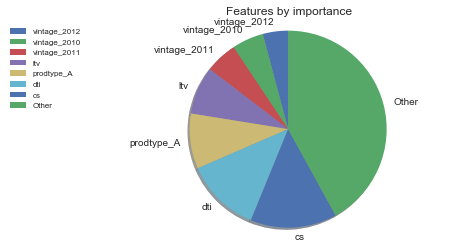

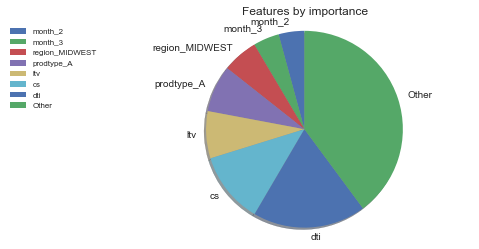

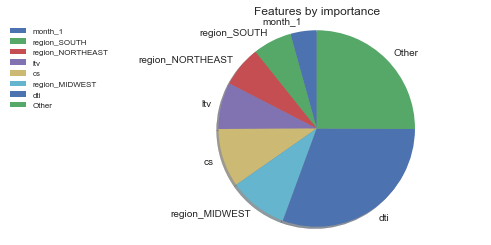

In [24]:
feature_importances(default_features)
feature_importances(balance_features)
feature_importances(pp_features)

Results for the random forest classifier-- a binary classifier that simply determines whether an error is a hotspot or not. 

In [25]:
print "default hotspot"
print(classification_report(default_hotspot, default_rfr.predict(df_x).round()))

print "pp hotspot"
print(classification_report(pp_hotspot, pp_rfr.predict(df_x).round()))

print "balance hotspot"
print(classification_report(balance_hotspot, balance_rfr.predict(df_x).round()))


default hotspot
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    226438
          1       0.98      0.97      0.98     15482

avg / total       1.00      1.00      1.00    241920

pp hotspot
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    227542
          1       0.99      0.97      0.98     14378

avg / total       1.00      1.00      1.00    241920

balance hotspot
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    224978
          1       0.99      0.97      0.98     16942

avg / total       1.00      1.00      1.00    241920



# Cluster for each time series

To demonstrate visual intuition surrounding the problem, I also illustrate a clustered representation of the model. The model is trained on 29 separate features, so to plot, some dimensionality reduction techniques must take place. For this, I used Principal Component Analysis (PCA) as a built-in initializer when creating a 2D representation using T-distributed Stochastic Neighbor Embedding (T-SNE). T-SNE converts similarities between data points to joint probabilities and minimizes the Kullback-Leibler divergence between the joint probabilities of the low dimensional embedding and the high dimensional data. 

In [26]:
#Imports 
from sklearn import manifold
from sklearn.manifold import TSNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=50)

In [27]:
# Apply transformations on each label (500 random samples each)
Y = tsne.fit_transform(df_x.sample(500))
Y_default = tsne.fit_transform(default_df.sample(500))
Y_pp = tsne.fit_transform(pp_df.sample(500))
Y_balance = tsne.fit_transform(balance_df.sample(500))

Although T-SNE is an excellent tool, it is not useful for this case since no clear distinction can be made between non-hotspot samples and hotspot samples. Around 20-30% (give or take) of the plotted samples can be estimated to be hotspots but not reliably.

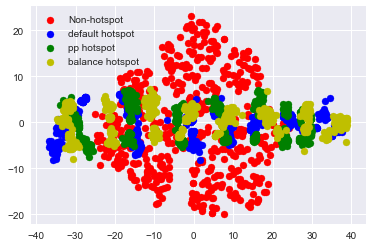

In [28]:
# Plot the samples
plt.scatter(Y[:, 0], Y[:, 1], c='r', cmap=plt.cm.Spectral, label='Non-hotspot')
plt.scatter(Y_default[:, 0], Y_default[:, 1], c='b', cmap=plt.cm.Spectral, label="default hotspot")
plt.scatter(Y_pp[:, 0], Y_pp[:, 1], c='g', cmap=plt.cm.Spectral, label='pp hotspot')
plt.scatter(Y_balance[:, 0], Y_balance[:, 1], c='y', cmap=plt.cm.Spectral, label='balance hotspot')
plt.legend()

# Conclusion

Given the difficulty of identifying large prediction errors known as hotspots, I have successfully developed a model capable of predicting when a sample is likely to cause a large prediction error. This model incorporates a random forest where the prominent decision features are easily accessible to an analyst.  Furthermore, the precision, accuracy, and recall scores indicate that this model is neither overfit nor underfit to the data. 